# Project: Identify Customer Segments

# Unsupervised Learning


### Student = Theodore van Kessel

### see README.md in this Github for overall information


In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [146]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [147]:
# Load in the general demographics data.
azdias_subset_df = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';');

# Load in the feature summary file.
feature_summary_df = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';');


In [148]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias_subset_df.head())
print("azdias_subset_df Shape: ", azdias_subset_df.shape)
print(feature_summary_df.head())
print("feature_summary_df Shape: ", feature_summary_df.shape)

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4            0   
1                      4                 5

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [149]:
# Identify missing or unknown data values and convert them to NaNs.

# step 1 find the natural nans
num_nat_nans = azdias_subset_df.isna().sum().sum()
print("number of natural nans: ", num_nat_nans)

# find the missing or unknown based on the feature summary
for attribute, miss_index in zip(feature_summary_df['attribute'], feature_summary_df['missing_or_unknown']):
    missing_values = miss_index.strip('[]').split(',')
    missing_values = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_values]
    if missing_values != ['']:
        azdias_subset_df[attribute] = azdias_subset_df[attribute].replace(missing_values, np.nan)

num_final_nans = azdias_subset_df.isna().sum().sum()
print("number of final nans: ", num_final_nans)

total_data = azdias_subset_df.shape[0]*azdias_subset_df.shape[1]
percent_bad_data = 100*num_final_nans/total_data
print("percent bad data: ", percent_bad_data)


number of natural nans:  4896838
number of final nans:  8373929
percent bad data:  11.054139407027648


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

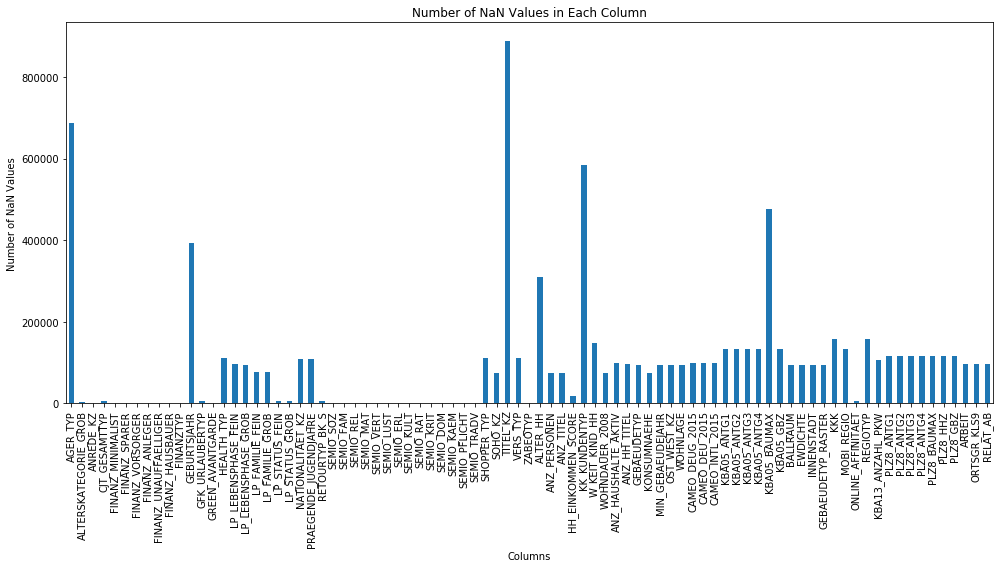

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [150]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Calculate the number of NaN values in each column
nan_counts = azdias_subset_df.isna().sum()

# Create a bar plot
plt.figure(figsize=(14, 8))  # Adjust the figure size as needed
nan_counts.plot(kind="bar")
plt.title("Number of NaN Values in Each Column")
plt.xlabel("Columns")
plt.ylabel("Number of NaN Values")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

print(nan_counts)


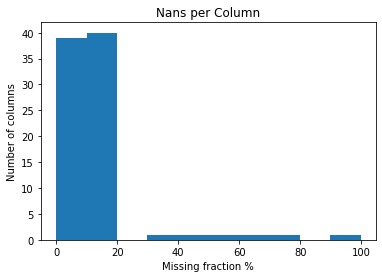

count    85.000000
mean     11.054139
std      16.449815
min       0.000000
25%       0.000000
50%      10.451729
75%      13.073637
max      99.757636
dtype: float64
ZABEOTYP                  0.000000
SEMIO_TRADV               0.000000
SEMIO_PFLICHT             0.000000
SEMIO_KAEM                0.000000
SEMIO_DOM                 0.000000
SEMIO_KRIT                0.000000
SEMIO_RAT                 0.000000
SEMIO_KULT                0.000000
SEMIO_ERL                 0.000000
SEMIO_LUST                0.000000
SEMIO_VERT                0.000000
SEMIO_MAT                 0.000000
SEMIO_REL                 0.000000
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
FINANZ_VORSORGER          0.000000
ANREDE_KZ                 0.000000
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
GREEN_AVANTGARDE          0.000000
FINANZTYP                 0.

In [151]:
# Investigate patterns in the amount of missing data in each column.

# lets start with a histogram
missing_fraction_pc = 100*azdias_subset_df.isna().sum()/azdias_subset_df.shape[0]
plt.hist(missing_fraction_pc)
plt.title('Nans per Column')
plt.xlabel('Missing fraction %')
plt.ylabel('Number of columns');
plt.show()

print(missing_fraction_pc.describe())

# sort and show 
missing_fraction_pc.sort_values(ascending=True,inplace=True)
print(missing_fraction_pc)

In [152]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# In the sorted missing_fraction_pc, there appears to be a natural break at 25% (see below)
missing_fraction_pc = 100*azdias_subset_df.isna().sum()/azdias_subset_df.shape[0]
missing_fraction_pc.sort_values(ascending=True,inplace=True)
columns_to_drop = missing_fraction_pc[missing_fraction_pc > 25.0]
print(columns_to_drop)

column_names_to_drop = columns_to_drop.keys().tolist() 
print("columns to drop: ", column_names_to_drop)

ALTER_HH        34.813699
GEBURTSJAHR     44.020282
KBA05_BAUMAX    53.468668
KK_KUNDENTYP    65.596749
AGER_TYP        76.955435
TITEL_KZ        99.757636
dtype: float64
columns to drop:  ['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ']


In [153]:
# lets drop the columns
azdias_subset_df = azdias_subset_df.drop(column_names_to_drop, axis=1)
display(azdias_subset_df.head())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column
Looking at the features in the Azdias data columns and the percentage of missing data in the
sorted missing_fraction_pc, there appears to be a natural break between

>REGIOTYP                 17.735668

>ALTER_HH                 34.813699

at around 25%. Most columns have some data missing, but the amound jumps abruptly from 17.73% to 34.81% 
I will drop columns with more than 25% missing data. These 
columns to drop:  **['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ']**

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

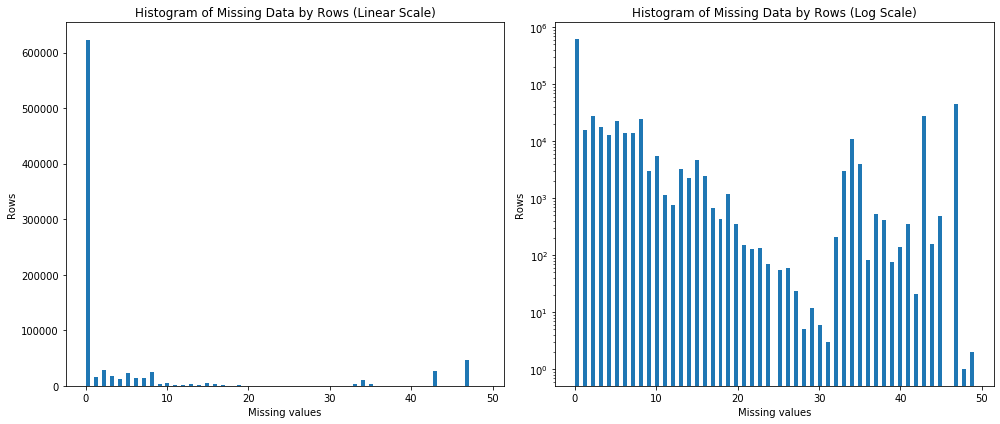

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

In [154]:
# # How much data is missing in each row of the dataset?

# Calculate the amount of missing data in each row
row_missing_data = azdias_subset_df.isnull().sum(axis=1)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the linear-scale histogram on the first subplot
ax1.hist(row_missing_data, bins=100)
ax1.set_title('Histogram of Missing Data by Rows (Linear Scale)')
ax1.set_xlabel('Missing values')
ax1.set_ylabel('Rows')

# Plot the log-scale histogram on the second subplot
ax2.hist(row_missing_data, bins=100, log=True)
ax2.set_title('Histogram of Missing Data by Rows (Log Scale)')
ax2.set_xlabel('Missing values')
ax2.set_ylabel('Rows')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# get stats for missing data
row_missing_data.describe()


In [155]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
cutoff = 33
missing_ge_cutoff = azdias_subset_df[row_missing_data >= cutoff]
missing_lt_cutoff = azdias_subset_df[row_missing_data < cutoff]
print(missing_lt_cutoff.shape)
print(missing_ge_cutoff.shape)

(798276, 79)
(92945, 79)


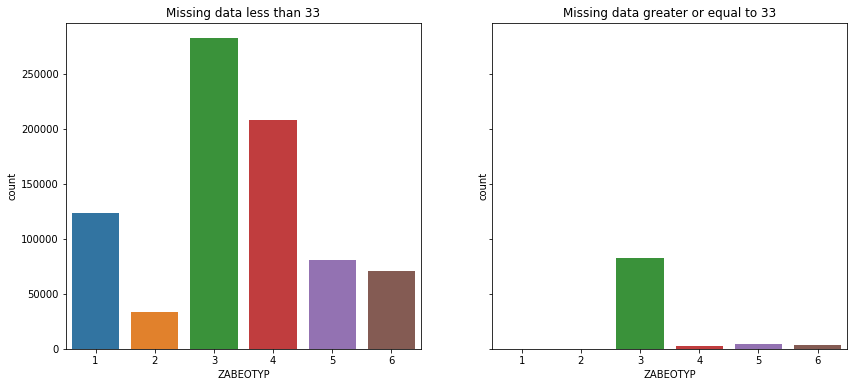

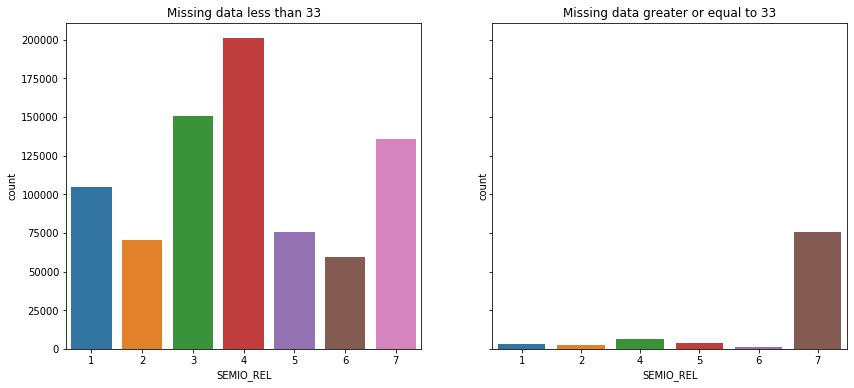

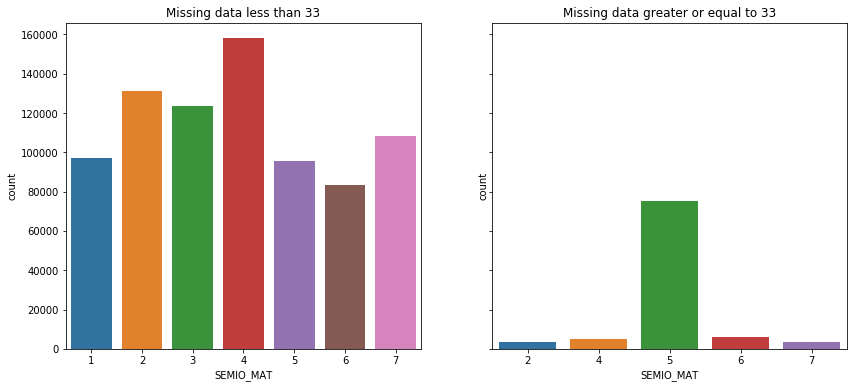

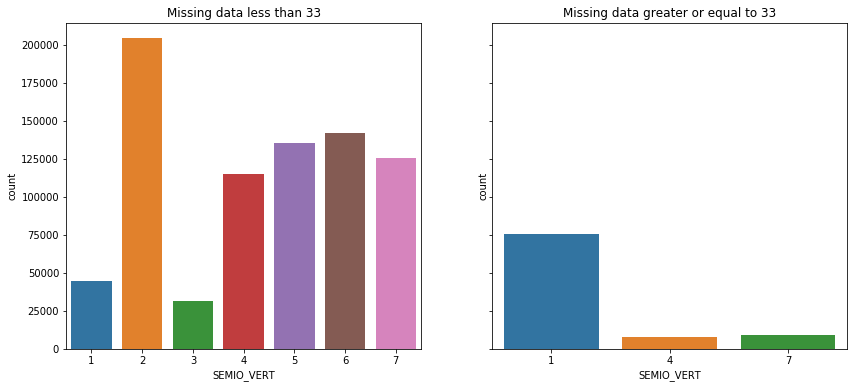

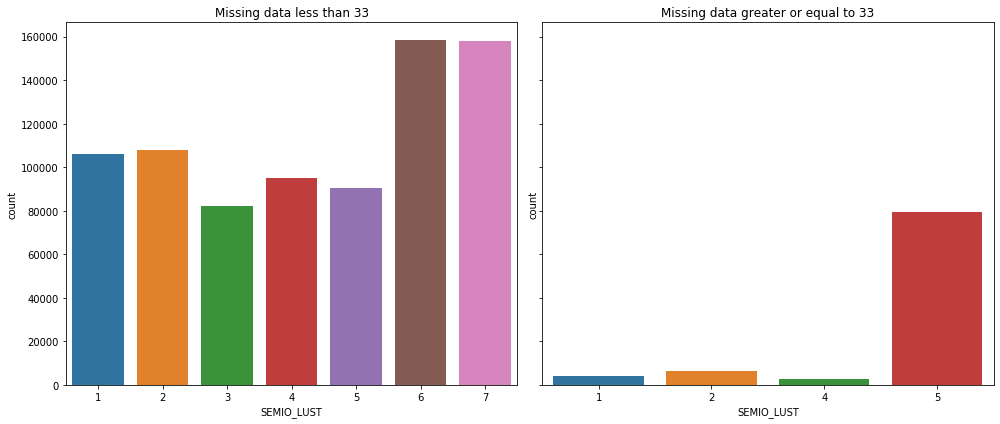

In [156]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

    
    
def plot_side_by_side(column, missing_ge_cutoff, missing_lt_cutoff, cutoff):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
    
    ax1.set_title('Missing data less than {}'.format(cutoff))
    sns.countplot(data=missing_lt_cutoff, x=column, ax=ax1)

    ax2.set_title('Missing data greater or equal to {}'.format(cutoff))
    sns.countplot(data=missing_ge_cutoff, x=column, ax=ax2)

def plot_low_missing_columns(dataframe, n=5):
    low_missing_columns = dataframe.isna().sum().sort_values().index[:n]

    for column in low_missing_columns:
        plot_side_by_side(column, missing_ge_cutoff, missing_lt_cutoff, cutoff)

# Assuming you have 'missing_ge_cutoff' and 'missing_lt_cutoff' DataFrames defined
# and azdias_subset_df loaded as your DataFrame

plot_low_missing_columns(azdias_subset_df)
plt.tight_layout()
plt.show()


#### Discussion 1.1.3: Assess Missing Data in Each Row

There appear to be 2 natural cutoff points in the histogram (see log histogram plot above) at 1 and 33. At both points, the amount of missing data abrubtly changes approximately 2 orders of magnitude. In the first case, it drops, while in the second case it grows. I chose 33 provisionally as the cutoff.

The data with lots of missing values are clearly different from the data with few missing values. This suggests a significant difference in how the missing data is distrubuted.
The rows with missing data is small compared with the number of rows. For a cutoff of 33, the number of rows lost is 92945 vs the total of 798276 or about 11.6%. I will leave them for now.



### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [157]:
# How many features are there of each data type?

# lets look in the feature summary at the type column and count the number of types
feature_type_counts = feature_summary_df['type'].value_counts()
print("feature types in summary: \n", feature_type_counts)
print("\n")

# now lets get a list of features that remain in azdias_subset_df after we deleted columns
feature_list = azdias_subset_df.keys().tolist()
feature_list = feature_summary_df[feature_summary_df['attribute'].isin(feature_list)] #extracting the needed features only
feature_counts = feature_list['type'].value_counts()
print("feature types in feature_summary_df: \n", feature_counts)

print(feature_list)

feature types in summary: 
 ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64


feature types in feature_summary_df: 
 ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64
                attribute information_level         type missing_or_unknown
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER          

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [158]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Filter features that are categorical
categorical_features = feature_list[feature_list['type'].isin(['categorical'])]

# Calculate the number of unique values for each categorical/mixed feature
unique_value_counts = {}
for feature in categorical_features['attribute']:
    unique_values = azdias_subset_df[feature].nunique()
    unique_value_counts[feature] = unique_values

# Print the number of unique values for each feature
for feature, count in unique_value_counts.items():
    # print(f"Feature '{feature}' has {count} unique values.")
    
    if count < 3:
        values = azdias_subset_df[feature].unique()
        print(f"Feature '{feature}' has {count} unique values - Enumerated values for '{feature}': {values}")
    else:
        print(f"Feature '{feature}' has {count} unique values.")


Feature 'ANREDE_KZ' has 2 unique values - Enumerated values for 'ANREDE_KZ': [1 2]
Feature 'CJT_GESAMTTYP' has 6 unique values.
Feature 'FINANZTYP' has 6 unique values.
Feature 'GFK_URLAUBERTYP' has 12 unique values.
Feature 'GREEN_AVANTGARDE' has 2 unique values - Enumerated values for 'GREEN_AVANTGARDE': [0 1]
Feature 'LP_FAMILIE_FEIN' has 11 unique values.
Feature 'LP_FAMILIE_GROB' has 5 unique values.
Feature 'LP_STATUS_FEIN' has 10 unique values.
Feature 'LP_STATUS_GROB' has 5 unique values.
Feature 'NATIONALITAET_KZ' has 3 unique values.
Feature 'SHOPPER_TYP' has 4 unique values.
Feature 'SOHO_KZ' has 2 unique values - Enumerated values for 'SOHO_KZ': [nan  1.  0.]
Feature 'VERS_TYP' has 2 unique values - Enumerated values for 'VERS_TYP': [nan  2.  1.]
Feature 'ZABEOTYP' has 6 unique values.
Feature 'GEBAEUDETYP' has 7 unique values.
Feature 'OST_WEST_KZ' has 2 unique values - Enumerated values for 'OST_WEST_KZ': [nan 'W' 'O']
Feature 'CAMEO_DEUG_2015' has 9 unique values.
Featur

In [159]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Re-encode 'OST_WEST_KZ' values as integers
azdias_subset_df['OST_WEST_KZ'] = azdias_subset_df['OST_WEST_KZ'].replace({'W': 0, 'O': 1})

# Print the first few rows to verify the re-encoding
print(azdias_subset_df['OST_WEST_KZ'].head())


0    NaN
1    0.0
2    0.0
3    0.0
4    0.0
Name: OST_WEST_KZ, dtype: float64


In [160]:
# we will drop the categorical variables with 3 or more unique values

# Filter features that are categorical
categorical_features = feature_list[feature_list['type'].isin(['categorical'])]
# Calculate the number of unique values for each categorical/mixed feature
unique_value_counts = {}
for feature in categorical_features['attribute']:
    unique_values = azdias_subset_df[feature].nunique()
    unique_value_counts[feature] = unique_values

# Create a list of categorical columns to drop with unique values >= 3
categorical_columns_to_drop = [feature for feature, count in unique_value_counts.items() if count >= 3]

# Print the list of categorical/mixed columns to drop
print("Categorical columns to drop:")
print(categorical_columns_to_drop)


Categorical columns to drop:
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [161]:
# now I will drop them from the dataframe

# Drop the list of columns from the DataFrame
azdias_subset_df = azdias_subset_df.drop(columns=categorical_columns_to_drop)

In [162]:
print(azdias_subset_df.head())

   ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   2.0          1                  3              4   
1                   1.0          2                  1              5   
2                   3.0          2                  1              4   
3                   4.0          2                  4              2   
4                   3.0          1                  4              3   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0                 3               5                      5                 3   
1                 2               5                      4                 5   
2                 1               2                      3                 5   
3                 5               2                      1                 2   
4                 4               1                      3                 2   

   GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  \
0        

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I identified the 18 categorical features in the dataset then
> re-encoded 'OST_WEST_KZ' "W" to 0 and "O" as 1

> dropped the categorical features with >= 3 unique values. I did this to preserve the simplicity of the dataset for now..
    One hot encoding would introduce a massive number of columns.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [163]:
# first lets have a look at mixed features
# Filter features that are mixed

categorical_features = feature_list[feature_list['type'].isin(['mixed'])]

# Calculate the number of unique values for each mixed feature
unique_value_counts = {}
for feature in categorical_features['attribute']:
    unique_values = azdias_subset_df[feature].nunique()
    unique_value_counts[feature] = unique_values

# Print the number of unique values for each feature
for feature, count in unique_value_counts.items():
    # print(f"Feature '{feature}' has {count} unique values.")
    if count < 3:
        values = azdias_subset_df[feature].unique()
        print(f"Feature '{feature}' has {count} unique values - Enumerated values for '{feature}': {values}")
    else:
        print(f"Feature '{feature}' has {count} unique values.")

Feature 'LP_LEBENSPHASE_FEIN' has 40 unique values.
Feature 'LP_LEBENSPHASE_GROB' has 12 unique values.
Feature 'PRAEGENDE_JUGENDJAHRE' has 15 unique values.
Feature 'WOHNLAGE' has 8 unique values.
Feature 'CAMEO_INTL_2015' has 21 unique values.
Feature 'PLZ8_BAUMAX' has 5 unique values.


In [164]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
"""
from the Data_Dictionary.md
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)
"""
decade_dict={1:1,2:1,
             3:2,4:2,
             5:3,6:3,7:3,
             8:4,9:4,
             10:5,11:5,12:5,13:5,14:6,15:6}
movement_dict={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}

# add new columns to azdias_subset_df  PJ_DECADE AND PJ_MOVEMENT by cloning "PRAEGENDE_JUGENDJAHRE"
azdias_subset_df["PJ_DECADE"] = azdias_subset_df["PRAEGENDE_JUGENDJAHRE"]
azdias_subset_df["PJ_MOVEMENT"] = azdias_subset_df["PRAEGENDE_JUGENDJAHRE"]

# remap the data in each column to the new values according to the respective dictionary
azdias_subset_df["PJ_DECADE"] = azdias_subset_df["PJ_DECADE"].map(decade_dict)
azdias_subset_df["PJ_MOVEMENT"] = azdias_subset_df["PJ_MOVEMENT"].map(movement_dict)
print(azdias_subset_df["PJ_DECADE"].head())
print(azdias_subset_df["PJ_MOVEMENT"].head())

# delete the original column "PRAEGENDE_JUGENDJAHRE"
azdias_subset_df = azdias_subset_df.drop(columns=["PRAEGENDE_JUGENDJAHRE"])

0    NaN
1    6.0
2    6.0
3    4.0
4    4.0
Name: PJ_DECADE, dtype: float64
0    NaN
1    1.0
2    0.0
3    1.0
4    1.0
Name: PJ_MOVEMENT, dtype: float64


In [165]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
"""
from the Data_Dictionary.md
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown
"""
# remap the above mixed categories using a dictionary for wealth and life-stage
wealth_dict ={'11':1,'12':1,'13':1,'14':1,'15':1,
            '21':2,'22':2,'23':2,'24':2,'25':2,
            '31':3,'32':3,'33':3,'34':3,'35':3,
            '41':4,'42':4,'43':4,'44':4,'45':4,
            '51':5,'52':5,'53':5,'54':5,'55':5
            }
life_stage_dict ={'11':1,'12':2,'13':3,'14':4,'15':5,
            '21':1,'22':2,'23':3,'24':4,'25':5,
            '31':1,'32':2,'33':4,'34':4,'35':5,
            '41':1,'42':2,'43':3,'44':4,'45':5,
            '51':1,'52':2,'53':3,'54':4,'55':5
            }
# add new columns to azdias_subset_df  CI_WEALTH AND CI_LIFE_STAGE by cloning "CAMEO_INTL_2015"
azdias_subset_df["CI_WEALTH"] = azdias_subset_df["CAMEO_INTL_2015"]
azdias_subset_df["CI_LIFE_STAGE"] = azdias_subset_df["CAMEO_INTL_2015"]

# remap the data in each column to the new values according to the respective dictionary
azdias_subset_df["CI_WEALTH"] = azdias_subset_df["CI_WEALTH"].map(wealth_dict)
azdias_subset_df["CI_LIFE_STAGE"] = azdias_subset_df["CI_LIFE_STAGE"].map(life_stage_dict)
print(azdias_subset_df["CI_WEALTH"].head())
print(azdias_subset_df["CI_LIFE_STAGE"].head())

# delete the original column "CAMEO_INTL_2015"
azdias_subset_df = azdias_subset_df.drop(columns=["CAMEO_INTL_2015"])

0    NaN
1    5.0
2    2.0
3    1.0
4    4.0
Name: CI_WEALTH, dtype: float64
0    NaN
1    1.0
2    4.0
3    2.0
4    3.0
Name: CI_LIFE_STAGE, dtype: float64


In [166]:
# drop remaining mixed features 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'
azdias_subset_df = azdias_subset_df.drop(columns=['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'])

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I have engineered the mixed feature columns as follows:

>I have created 2 feature columns for "PJ_DECADE" and "PJ_MOVEMENT" to substitute for "PRAEGENDE_JUGENDJAHRE" and remapped the values using 2 dictionaries as a means of converting a single mixed variable to 2 independent variables.

>I have created 2 feature columns for "CI_WEALTH" and "CI_LIFE_STAGE" to substitute for "CAMEO_INTL_2015" and remapped the values using 2 dictionaries as a means of converting a single mixed variable to 2 independent variables.

>Finally, in the interrest of simplicity, I dropped the 4 remaining mixed columns 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [167]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# I will clean up the nan's as suggested in step 2.

# Impute the NaNs
imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
azdias_subset_df_xform = imp_mean.fit_transform(azdias_subset_df)
azdias_subset_df = pd.DataFrame(azdias_subset_df_xform, columns=azdias_subset_df.columns)
print('NaN values in the dataset after filling NaNs:', azdias_subset_df.isna().sum().sum())



NaN values in the dataset after filling NaNs: 0


In [168]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# I will provisionally keep the current state 


In [169]:
# Save the DataFrame to a CSV file as a reference
output_file_name = 'Udacity_AZDIAS_Subset_cleaned_reference.csv'
azdias_subset_df.to_csv(output_file_name, index=False)

print("DataFrame saved to: ", output_file_name)

DataFrame saved to:  Udacity_AZDIAS_Subset_cleaned_reference.csv


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [170]:
def clean_data(demographics_df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # Load in the feature summary file.
    print("    loading feature summary file")
    feature_summary_df = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';');
    feature_list = demographics_df.keys().tolist()
    feature_list = feature_summary_df[feature_summary_df['attribute'].isin(feature_list)] #extracting only needed features
    
    # convert missing value codes into NaNs, ... _____________________________________________________________
    print("    Convert missing or unknown data to nans")
    # Identify missing or unknown data values and convert them to NaNs.
    # find the natural nans
    num_nat_nans = demographics_df.isna().sum().sum()
    print("    Number of natural nans: ", num_nat_nans)

    # find the missing or unknown based on the feature summary and convert to nans
    for attribute, miss_index in zip(feature_summary_df['attribute'], feature_summary_df['missing_or_unknown']):
        missing_values = miss_index.strip('[]').split(',')
        missing_values = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_values]
        if missing_values != ['']:
            demographics_df[attribute] = demographics_df[attribute].replace(missing_values, np.nan)

    num_final_nans = demographics_df.isna().sum().sum()
    print("    Number of final nans: ", num_final_nans)

    total_data = demographics_df.shape[0]*demographics_df.shape[1]
    percent_bad_data = 100*num_final_nans/total_data
    print("    Percent bad data: ", percent_bad_data)
    
    
    # remove selected columns and rows, ...-----------------------------------------------------
    
    # ================== drop columns with more than 25% missing data ===========================
    
    # in the sorted missing_fraction_pc, there appears to be a natural break at 25% (see below)
    missing_fraction_pc = 100*demographics_df.isna().sum()/demographics_df.shape[0]
    missing_fraction_pc.sort_values(ascending=True,inplace=True)
    columns_to_drop = missing_fraction_pc[missing_fraction_pc > 25.0]
    column_names_to_drop = columns_to_drop.keys().tolist()
    
    if all(column in demographics_df.columns for column in column_names_to_drop):
        print("        All columns exist in the DataFrame.")
    else:
        missing_columns = [column for column in columns_to_check if column not in dataframe.columns]
        print("        The following columns are missing:", missing_columns)
    
    # Drop the columns
    print("    Dropping columns with > 25% missing data: ")
    demographics_df = demographics_df.drop(column_names_to_drop, axis=1)
    
    # select, re-encode, and engineer column values.
    
    # Re-encode 'OST_WEST_KZ' values as integers
    print("    Re-encoding OST_WEST_KZ")
    if 'OST_WEST_KZ' in demographics_df:
        demographics_df['OST_WEST_KZ'] = demographics_df['OST_WEST_KZ'].replace({'W': 0, 'O': 1})
    
    # =========== drop the categorical variables with 3 or more unique values ==================

    # Filter features that are categorical
    categorical_features = feature_list[feature_list['type'].isin(['categorical'])]
    categorical_features = categorical_features[categorical_features['attribute'].isin(demographics_df.columns)]
    
    # Calculate the number of unique values for each categorical/mixed feature
    unique_value_counts = {}
    for feature in categorical_features['attribute']:
        unique_values = demographics_df[feature].nunique()
        unique_value_counts[feature] = unique_values

    # Create a list of categorical columns to drop with unique values >= 3
    categorical_columns_to_drop = [feature for feature, count in unique_value_counts.items() if count >= 3]
    
    if all(column in demographics_df.columns for column in categorical_columns_to_drop):
        print("        All columns exist in the DataFrame.")
    else:
        missing_columns = [column for column in columns_to_check if column not in dataframe.columns]
        print("        The following columns are missing:", missing_columns)

    # Drop the list of columns from the DataFrame
    print("    Drop remaining categorical columns")
    demographics_df = demographics_df.drop(columns=categorical_columns_to_drop)
    
    # =========== Create two new variables from "PRAEGENDE_JUGENDJAHRE" ==========================
    
    decade_dict={1:1,2:1,
             3:2,4:2,
             5:3,6:3,7:3,
             8:4,9:4,
             10:5,11:5,12:5,13:5,14:6,15:6}
    movement_dict={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
    
    # add new columns to demographics_df  PJ_DECADE AND PJ_MOVEMENT by cloning "PRAEGENDE_JUGENDJAHRE"
    if 'PRAEGENDE_JUGENDJAHRE' in demographics_df:
        print("    Creating new variables for PRAEGENDE_JUGENDJAHRE")
        
        demographics_df["PJ_DECADE"] = demographics_df["PRAEGENDE_JUGENDJAHRE"]
        demographics_df["PJ_MOVEMENT"] = demographics_df["PRAEGENDE_JUGENDJAHRE"]

        # remap the data in each column to the new values according to the respective dictionary
        demographics_df["PJ_DECADE"] = demographics_df["PJ_DECADE"].map(decade_dict)
        demographics_df["PJ_MOVEMENT"] = demographics_df["PJ_MOVEMENT"].map(movement_dict)

        # delete the original column "PRAEGENDE_JUGENDJAHRE"
        demographics_df = demographics_df.drop(columns=["PRAEGENDE_JUGENDJAHRE"])
    
    # =========== Create two new variables from "CAMEO_INTL_2015" ==========================

    wealth_dict ={'11':1,'12':1,'13':1,'14':1,'15':1,
            '21':2,'22':2,'23':2,'24':2,'25':2,
            '31':3,'32':3,'33':3,'34':3,'35':3,
            '41':4,'42':4,'43':4,'44':4,'45':4,
            '51':5,'52':5,'53':5,'54':5,'55':5
            }
    life_stage_dict ={'11':1,'12':2,'13':3,'14':4,'15':5,
                '21':1,'22':2,'23':3,'24':4,'25':5,
                '31':1,'32':2,'33':4,'34':4,'35':5,
                '41':1,'42':2,'43':3,'44':4,'45':5,
                '51':1,'52':2,'53':3,'54':4,'55':5
                }
    if 'PRAEGENDE_JUGENDJAHRE' in demographics_df:
        print("    creating new variables for CAMEO_INTL_2015")
        # add new columns to demographics_df  CI_WEALTH AND CI_LIFE_STAGE by cloning "CAMEO_INTL_2015"
        demographics_df["CI_WEALTH"] = demographics_df["CAMEO_INTL_2015"]
        demographics_df["CI_LIFE_STAGE"] = demographics_df["CAMEO_INTL_2015"]

        # remap the data in each column to the new values according to the respective dictionary
        demographics_df["CI_WEALTH"] = demographics_df["CI_WEALTH"].map(wealth_dict)
        demographics_df["CI_LIFE_STAGE"] = demographics_df["CI_LIFE_STAGE"].map(life_stage_dict)

        # delete the original column "CAMEO_INTL_2015"
        demographics_df = demographics_df.drop(columns=["CAMEO_INTL_2015"])
    
    # ====== drop remaining mixed features =====================================================
    print("    Dropping remaining mixed features")
    
#     demographics_df = demographics_df.drop(columns=['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
#                                                       'WOHNLAGE', 'PLZ8_BAUMAX'])
    if 'LP_LEBENSPHASE_FEIN' in demographics_df: demographics_df = demographics_df.drop(columns=['LP_LEBENSPHASE_FEIN'])
    if 'LP_LEBENSPHASE_GROB' in demographics_df: demographics_df = demographics_df.drop(columns=['LP_LEBENSPHASE_GROB'])
    if 'WOHNLAGE' in demographics_df:demographics_df = demographics_df.drop(columns=['WOHNLAGE'])
    if 'PLZ8_BAUMAX' in demographics_df:demographics_df = demographics_df.drop(columns=['PLZ8_BAUMAX'])
        
#     # Impute the NaNs ============ removed based on review recommendation ======================
#     imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
#     demographics_df_xform = imp_mean.fit_transform(demographics_df)
#     demographics_df = pd.DataFrame(demographics_df_xform, columns=demographics_df.columns)
#     print('    NaN values in the dataset after imputing:', demographics_df.isna().sum().sum())
    
    # Return the cleaned dataframe.
    return(demographics_df)


### we wiil reload the dataframe and clean it with the clean_data function above

In [171]:
# Load in the general demographics data.
azdias_subset_df = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';');
print("data loaded")

azdias_subset_df = clean_data(azdias_subset_df)
print("data cleaned")


data loaded
    loading feature summary file
    Convert missing or unknown data to nans
    Number of natural nans:  4896838
    Number of final nans:  8373929
    Percent bad data:  11.054139407027648
        All columns exist in the DataFrame.
    Dropping columns with > 25% missing data: 
    Re-encoding OST_WEST_KZ
        All columns exist in the DataFrame.
    Drop remaining categorical columns
    Creating new variables for PRAEGENDE_JUGENDJAHRE
    Dropping remaining mixed features
data cleaned


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [172]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Impute the NaNs
impute_freq = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
azdias_subset_df_xform = impute_freq.fit_transform(azdias_subset_df)
azdias_subset_df = pd.DataFrame(azdias_subset_df_xform, columns=azdias_subset_df.columns)
print('NaN values in the dataset after filling NaNs:', azdias_subset_df.isna().sum().sum())


NaN values in the dataset after filling NaNs: 0


In [174]:
# Apply feature scaling to the general population demographics data.
# azdias_subset_df = pd.DataFrame(scaler.fit_transform(aazdias_subset_df.head), columns = azdias_subset_df.columns)

# I have broken out the elements of the above so I can use the scaler_gp later for the customer data
scaler_gp = StandardScaler()
scaler_gp.fit(azdias_subset_df)
scaled_data = scaler_gp.transform(azdias_subset_df)
azdias_subset_df= pd.DataFrame(scaled_data, columns=azdias_subset_df.columns)


In [175]:
print(azdias_subset_df.head())

   ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0             -0.751680  -1.045218          -0.056416       0.804890   
1             -1.743339   0.956738          -1.570358       1.487601   
2              0.239980   0.956738          -1.570358       0.804890   
3              1.231640   0.956738           0.700556      -0.560532   
4              0.239980  -1.045218           0.700556       0.122179   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0         -0.303378        1.285741               1.429871         -0.055511   
1         -1.059731        1.285741               0.757254          1.422415   
2         -1.816084       -0.675554               0.084637          1.422415   
3          1.209329       -0.675554              -1.260597         -0.794475   
4          0.452976       -1.329319               0.084637         -0.794475   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0         -0.

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I considered the following scalers:StandardScaler, MinMaxScaler, RobustScaler and Normalizer. I settled on StandardScaler as a good starting point due to its scaling to zero with unit variance.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

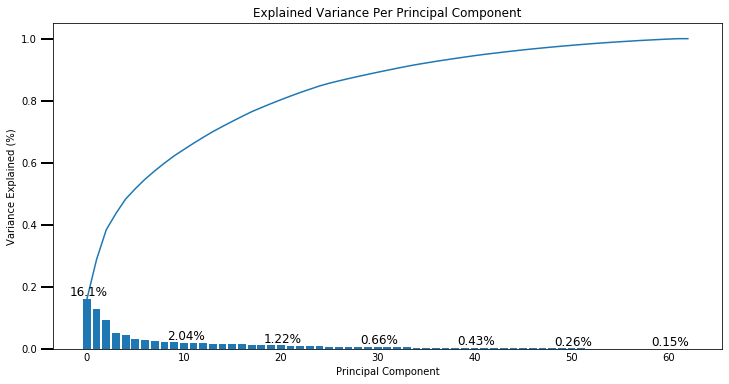

In [176]:
# Apply PCA to the data.
pca_model = PCA()
azdias_subset_pca = pca_model.fit_transform(azdias_subset_df)

# Investigate the variance accounted for by each principal component.
def scree_plot(pca_model):
    num_components = len(pca_model.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca_model.explained_variance_ratio_
 
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
      if(i%10==0):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca_model)


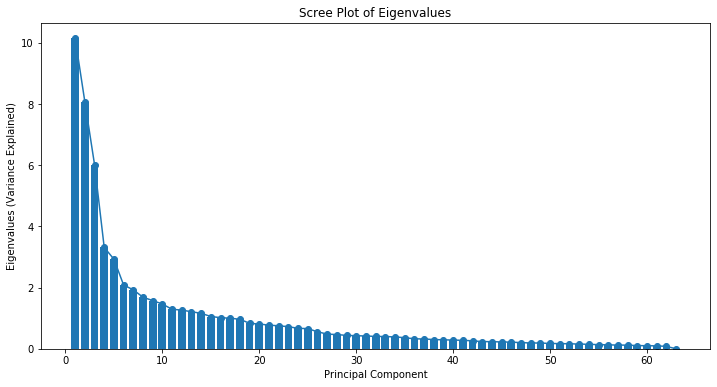

In [177]:
# Investigate the variance accounted for by each principal component.
"""
The Scree plot above shows the cumulative variance explained in addition to the contribution of each component. 
The chart below shows the Eigenvalues more clearly. We see the "Knee" that is often referred to at 
around the 3rd or 5th component
"""

# Get the eigenvalues (variance explained) from the PCA
eigenvalues = pca_model.explained_variance_

# Create a scree plot with eigenvalues
plt.figure(figsize=(12, 6))
plt.bar(np.arange(1, len(eigenvalues) + 1), eigenvalues)
plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalues (Variance Explained)")
plt.title("Scree Plot of Eigenvalues")
plt.show()


(891221, 20)


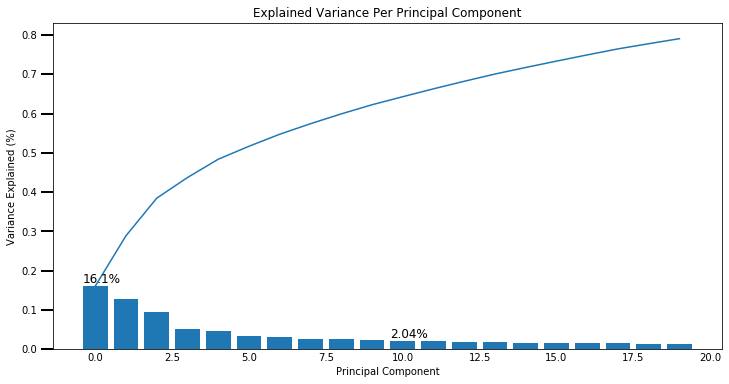

In [178]:
# Re-apply PCA to the data while selecting for number of components to retain.

# I will go with the 80/20 split
pca_model_80_20 = PCA(n_components=20)
azdias_subset_pca_80_20 = pca_model_80_20.fit_transform(azdias_subset_df)

scree_plot(pca_model_80_20)

# we see as expected that the reduced model accounts for 80% of the variance
print(azdias_subset_pca_80_20.shape)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

I went with an 80/20 split and selected the number of features as 20 which you can see in the chart above accounts for 80% of the variance. This seems ot me to be a good balance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

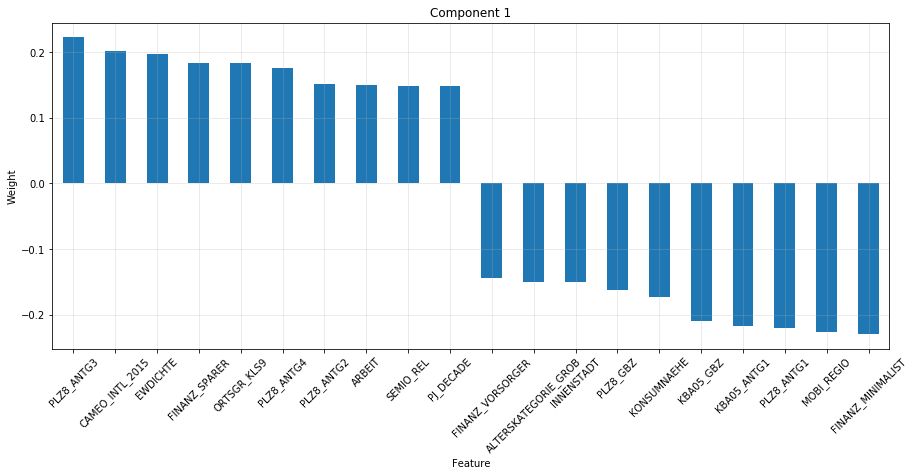

weights:
PLZ8_ANTG3              0.222264
CAMEO_INTL_2015         0.202078
EWDICHTE                0.197650
FINANZ_SPARER           0.183673
ORTSGR_KLS9             0.183378
PLZ8_ANTG4              0.175359
PLZ8_ANTG2              0.151931
ARBEIT                  0.149185
SEMIO_REL               0.148846
PJ_DECADE               0.147627
FINANZ_VORSORGER       -0.144422
ALTERSKATEGORIE_GROB   -0.150012
INNENSTADT             -0.150267
PLZ8_GBZ               -0.162157
KONSUMNAEHE            -0.173336
KBA05_GBZ              -0.208913
KBA05_ANTG1            -0.217395
PLZ8_ANTG1             -0.219601
MOBI_REGIO             -0.226181
FINANZ_MINIMALIST      -0.229061
dtype: float64


In [179]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_component_weights(df, pca, component):
    component_weights = pd.Series(pca.components_[component], index=df.columns)
    component_weights = component_weights.sort_values(ascending=False)
    return component_weights


def plot_component_weights(df, pca, component, feature_plot, figsize=(12, 6)):
    component_weights = map_component_weights(df, pca, component)
    top_weights = component_weights.head(feature_plot)
    bottom_weights = component_weights.tail(feature_plot)
    
    combined_weights = pd.concat([top_weights, bottom_weights])
    
    plt.figure(figsize=figsize)  # Adjust the figsize here
    combined_weights.plot(kind='bar')
    
    plt.title(f'Component {component+1}')
    plt.ylabel('Weight')
    plt.xlabel('Feature')
    plt.xticks(rotation=45)
    plt.grid(linewidth='0.5', alpha=0.5)
    plt.show()
    
    return combined_weights

component_weights = plot_component_weights(azdias_subset_df, pca_model_80_20, 0, 10, figsize=(15, 6)) 
print("weights:")
print(component_weights)





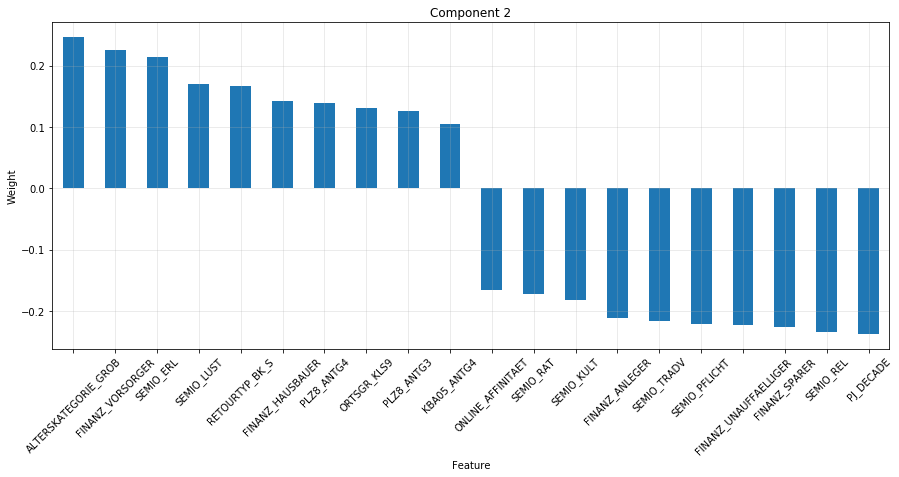

weights:
ALTERSKATEGORIE_GROB     0.246200
FINANZ_VORSORGER         0.225489
SEMIO_ERL                0.213592
SEMIO_LUST               0.169602
RETOURTYP_BK_S           0.166915
FINANZ_HAUSBAUER         0.142331
PLZ8_ANTG4               0.139406
ORTSGR_KLS9              0.130063
PLZ8_ANTG3               0.125462
KBA05_ANTG4              0.105099
ONLINE_AFFINITAET       -0.166543
SEMIO_RAT               -0.172059
SEMIO_KULT              -0.181580
FINANZ_ANLEGER          -0.211929
SEMIO_TRADV             -0.215621
SEMIO_PFLICHT           -0.221508
FINANZ_UNAUFFAELLIGER   -0.223482
FINANZ_SPARER           -0.226701
SEMIO_REL               -0.234276
PJ_DECADE               -0.237029
dtype: float64


In [180]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

component_weights = plot_component_weights(azdias_subset_df, pca_model_80_20, 1, 10, figsize=(15, 6)) 
print("weights:")
print(component_weights)

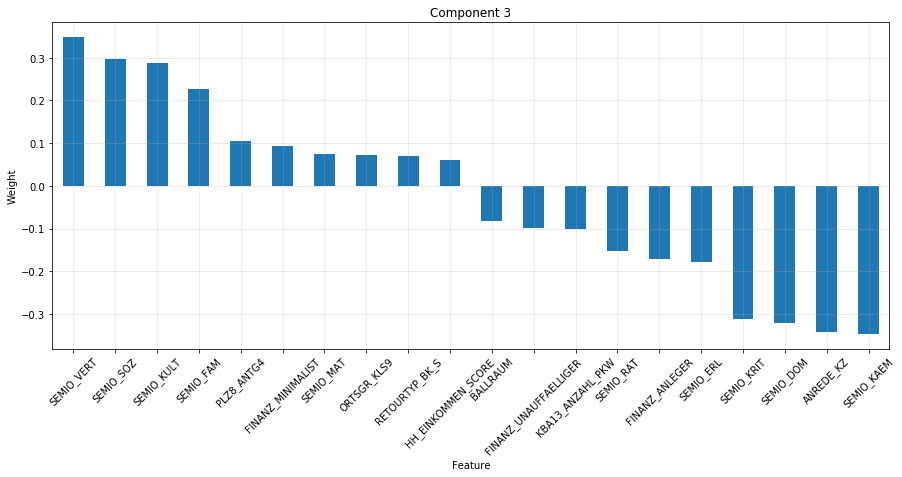

weights:
SEMIO_VERT               0.347968
SEMIO_SOZ                0.297318
SEMIO_KULT               0.287827
SEMIO_FAM                0.227539
PLZ8_ANTG4               0.104524
FINANZ_MINIMALIST        0.092762
SEMIO_MAT                0.074965
ORTSGR_KLS9              0.072879
RETOURTYP_BK_S           0.070553
HH_EINKOMMEN_SCORE       0.060899
BALLRAUM                -0.083045
FINANZ_UNAUFFAELLIGER   -0.097820
KBA13_ANZAHL_PKW        -0.102012
SEMIO_RAT               -0.153199
FINANZ_ANLEGER          -0.171545
SEMIO_ERL               -0.178507
SEMIO_KRIT              -0.311122
SEMIO_DOM               -0.319996
ANREDE_KZ               -0.341506
SEMIO_KAEM              -0.345919
dtype: float64


In [181]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

component_weights = plot_component_weights(azdias_subset_df, pca_model_80_20, 2, 10, figsize=(15, 6)) 
print("weights:")
print(component_weights)

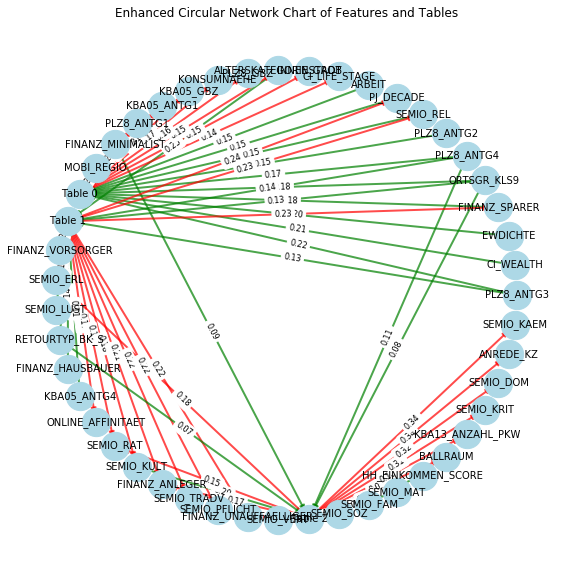

In [182]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the data for each table
table_0 = {
    "PLZ8_ANTG3": 0.219385,
    "CI_WEALTH": 0.207060,
    "EWDICHTE": 0.195989,
    "FINANZ_SPARER": 0.182699,
    "ORTSGR_KLS9": 0.179205,
    "PLZ8_ANTG4": 0.170521,
    "PLZ8_ANTG2": 0.150019,
    "SEMIO_REL": 0.148924,
    "PJ_DECADE": 0.147732,
    "ARBEIT": 0.147368,
    "CI_LIFE_STAGE": -0.142757,
    "INNENSTADT": -0.146558,
    "ALTERSKATEGORIE_GROB": -0.147996,
    "PLZ8_GBZ": -0.160094,
    "KONSUMNAEHE": -0.172890,
    "KBA05_GBZ": -0.205349,
    "KBA05_ANTG1": -0.216244,
    "PLZ8_ANTG1": -0.216774,
    "FINANZ_MINIMALIST": -0.225041,
    "MOBI_REGIO": -0.225273
}

table_1 = {
    "ALTERSKATEGORIE_GROB": 0.245557,
    "FINANZ_VORSORGER": 0.224861,
    "SEMIO_ERL": 0.213291,
    "SEMIO_LUST": 0.169254,
    "RETOURTYP_BK_S": 0.166777,
    "FINANZ_HAUSBAUER": 0.143035,
    "PLZ8_ANTG4": 0.140345,
    "ORTSGR_KLS9": 0.131118,
    "PLZ8_ANTG3": 0.126576,
    "KBA05_ANTG4": 0.105789,
    "ONLINE_AFFINITAET": -0.166693,
    "SEMIO_RAT": -0.171437,
    "SEMIO_KULT": -0.181502,
    "FINANZ_ANLEGER": -0.211439,
    "SEMIO_TRADV": -0.215174,
    "SEMIO_PFLICHT": -0.220875,
    "FINANZ_UNAUFFAELLIGER": -0.222895,
    "FINANZ_SPARER": -0.225870,
    "SEMIO_REL": -0.233712,
    "PJ_DECADE": -0.236351
}

table_2 = {
    "SEMIO_VERT": 0.347101,
    "SEMIO_SOZ": 0.297640,
    "SEMIO_KULT": 0.288327,
    "SEMIO_FAM": 0.227302,
    "PLZ8_ANTG4": 0.107237,
    "FINANZ_MINIMALIST": 0.089551,
    "SEMIO_MAT": 0.075550,
    "ORTSGR_KLS9": 0.075471,
    "RETOURTYP_BK_S": 0.069806,
    "HH_EINKOMMEN_SCORE": 0.062871,
    "BALLRAUM": -0.085303,
    "FINANZ_UNAUFFAELLIGER": -0.097137,
    "KBA13_ANZAHL_PKW": -0.103635,
    "SEMIO_RAT": -0.151048,
    "FINANZ_ANLEGER": -0.170773,
    "SEMIO_ERL": -0.178810,
    "SEMIO_KRIT": -0.310939,
    "SEMIO_DOM": -0.318841,
    "ANREDE_KZ": -0.340189,
    "SEMIO_KAEM": -0.344714
}


# Create a graph
G = nx.DiGraph()  # Directed graph to represent positive and negative relationships

# Add nodes for each feature
for feature in table_0.keys():
    G.add_node(feature)

# Add edges with positive and negative weights
for feature, weight in table_0.items():
    if weight > 0:
        G.add_edge(feature, "Table 0", weight=weight, color='green')
    else:
        G.add_edge("Table 0", feature, weight=-weight, color='red')

for feature, weight in table_1.items():
    if weight > 0:
        G.add_edge(feature, "Table 1", weight=weight, color='green')
    else:
        G.add_edge("Table 1", feature, weight=-weight, color='red')

for feature, weight in table_2.items():
    if weight > 0:
        G.add_edge(feature, "Table 2", weight=weight, color='green')
    else:
        G.add_edge("Table 2", feature, weight=-weight, color='red')

# Draw the circular network chart
plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G)
edges = G.edges(data=True)
edge_colors = [data['color'] for _, _, data in edges]
edge_labels = {(u, v): f"{data['weight']:.2f}" for u, v, data in edges}

nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue')
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, alpha=0.7, width=2, arrowstyle='-|>', arrowsize=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Enhanced Circular Network Chart of Features and Tables")
plt.axis('off')
plt.show()



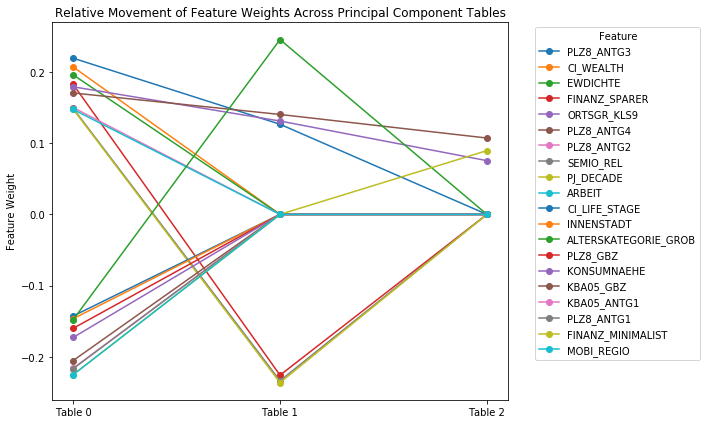

In [183]:


import matplotlib.pyplot as plt

# Define the data for each table (same as your provided data)

# Define the list of features
combined_features = list(table_0.keys())  # You can choose any of the tables since they have the same features

# Create a figure and axis
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot the relative movement of features
for feature in combined_features:
    y_values = [table_0.get(feature, 0), table_1.get(feature, 0), table_2.get(feature, 0)]
    relative_movement = [y_values[i] for i, y in enumerate(y_values)][0:]
    ax.plot(range(3), relative_movement, marker='o', label=feature)

# Customize the plot
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["Table 0", "Table 1", "Table 2"])
ax.set_ylabel("Feature Weight")
ax.set_title("Relative Movement of Feature Weights Across Principal Component Tables")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Feature")

plt.tight_layout()
plt.show()




### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

The numerical tables and the plots above show that the weights for a given feature move from positive to negative and back from component to component. Features appear and dissappear from the tables by component. 

#### Uniquely, I found there were two features that are positively weighted across all 3 components: 

    >PLZ8_ANTG4 (Number of 10+ family houses in the PLZ8 region) 
    
    >ORTSGR_KLS9 (Size of community)  
#### Another observation is that the dominant 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [184]:

cluster_counts = list(range(1, 21))

avg_dists = []

# Over a number of different cluster counts...
for count in cluster_counts:
    print("running count", count)
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=count, n_init=10)
    kmeans.fit(azdias_subset_pca_80_20)
    
    
    # compute the average within-cluster distances.
    avg_dist = np.abs(kmeans.score(azdias_subset_pca_80_20)) / len(azdias_subset_pca_80_20)
    avg_dists.append(avg_dist) 
    

running count 1
running count 2
running count 3
running count 4
running count 5
running count 6
running count 7
running count 8
running count 9
running count 10
running count 11
running count 12
running count 13
running count 14
running count 15
running count 16
running count 17
running count 18
running count 19
running count 20


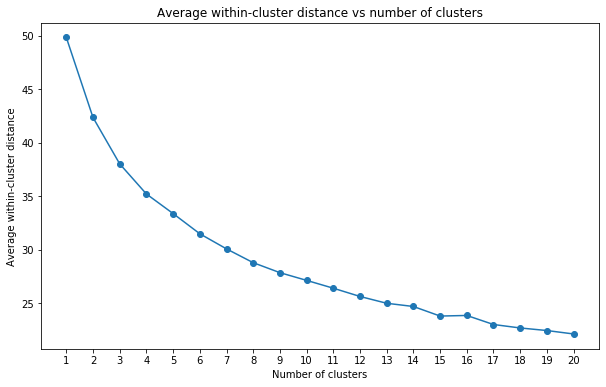

In [185]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(10,6))
plt.plot(cluster_counts, avg_dists, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster distance')
plt.title('Average within-cluster distance vs number of clusters')
plt.xticks(np.arange(cluster_counts[0], cluster_counts[-1]+1, step=1))
plt.show()

In [186]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
random_state = 42
kmeans_7 = KMeans(n_clusters = 7, n_init=10, random_state=random_state)
kmeans_7.fit(azdias_subset_pca_80_20)
general_kmeans_predict = kmeans_7.predict(azdias_subset_pca_80_20)

print("done")

done


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

To be consistant with my 80/20 choices in my pca model, I chose 7 clusters which reduces the average within cluster distance by approximately 80% in the kmeans model. This also corresponds to the "knee" of the distribution.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [187]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';');
print("data loaded")

# clean it
customers_clean = clean_data(customers)
print("data cleaned")
customers_clean=impute_nans(customers_clean)

print('Nan values in the dataset after cleaning:', customers_clean.isna().sum().sum())  # check for nans

# Add dummy columns filled with 0 to the customers_scaled DataFrame
diff_set=set(azdias_subset_df.columns) - set(customers_clean.columns)
diff_columns = list(diff_set)
customers_clean = customers_clean.assign(**{column: 0 for column in diff_columns})

# Impute the NaNs
impute_freq = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
customers_clean_xform = impute_freq.fit_transform(customers_clean)
customers_clean = pd.DataFrame(customers_clean_xform, columns=customers_clean.columns)
print('NaN values in the dataset after filling NaNs:', customers_clean.isna().sum().sum())

# Apply feature scaling to the customer data using the pre-trained scaler scaler_gp.
scaled_data = scaler_gp.transform(customers_clean)
customers_scaled = pd.DataFrame(scaled_data, columns=customers_clean.columns)
print("data scaled")

# PCA Transform 
customers_pca_transformed = pca_model_80_20.transform(customers_scaled)
print("data transformed with pca model")

# Predict
customers_kmeans_predict = kmeans_7.predict(customers_pca_transformed)
print("data predicicted with kmeans model")

data loaded
    loading feature summary file
    Convert missing or unknown data to nans
    Number of natural nans:  2252274
    Number of final nans:  3112918
    Percent bad data:  19.10888730922837
        All columns exist in the DataFrame.
    Dropping columns with > 25% missing data: 
    Re-encoding OST_WEST_KZ
        All columns exist in the DataFrame.
    Drop remaining categorical columns
    Dropping remaining mixed features
data cleaned
    NaN values in the dataset after imputing: 242669
Nan values in the dataset after cleaning: 242669
NaN values in the dataset after filling NaNs: 0
data scaled
data transformed with pca model
data predicicted with kmeans model


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

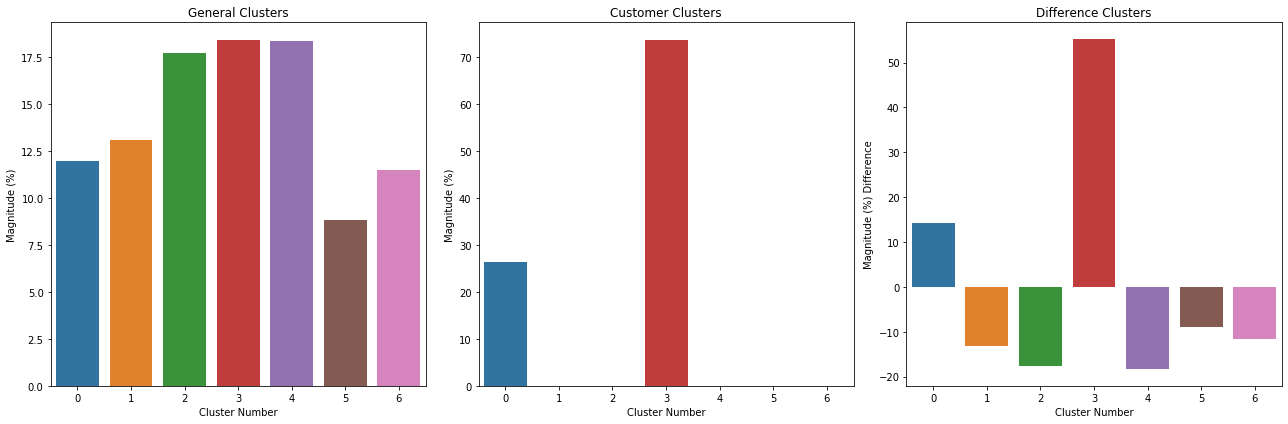

In [188]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Generate plots to compare the cluster information for each population and plot the difference

# Get cluster magnitudes
clusters = list(range(max(general_kmeans_predict) + 1))
rel_magnitude_general = pd.Series(general_kmeans_predict).value_counts(normalize=True)
rel_magnitude_customers = pd.Series(customers_kmeans_predict).value_counts(normalize=True)

# Reindex the series and fill missing with nans
rel_magnitude_general = rel_magnitude_general.reindex(clusters, fill_value=0)
rel_magnitude_customers = rel_magnitude_customers.reindex(clusters, fill_value=0)

# Calculate the percentage difference
percentage_difference = (rel_magnitude_customers - rel_magnitude_general) * 100

# Create subplots using Seaborn barplot
plt.figure(figsize=(18, 6))

# General Clusters Plot
plt.subplot(1, 3, 1)
sns.barplot(x=clusters, y=rel_magnitude_general * 100)
plt.xlabel('Cluster Number')
plt.ylabel('Magnitude (%)')
plt.title('General Clusters')

# Customer Clusters Plot
plt.subplot(1, 3, 2)
sns.barplot(x=clusters, y=rel_magnitude_customers * 100)
plt.xlabel('Cluster Number')
plt.ylabel('Magnitude (%)')
plt.title('Customer Clusters')

# Difference Clusters Plot
plt.subplot(1, 3, 3)
sns.barplot(x=clusters, y=percentage_difference)
plt.xlabel('Cluster Number')
plt.ylabel('Magnitude (%) Difference')
plt.title('Difference Clusters')

plt.tight_layout()
plt.show()


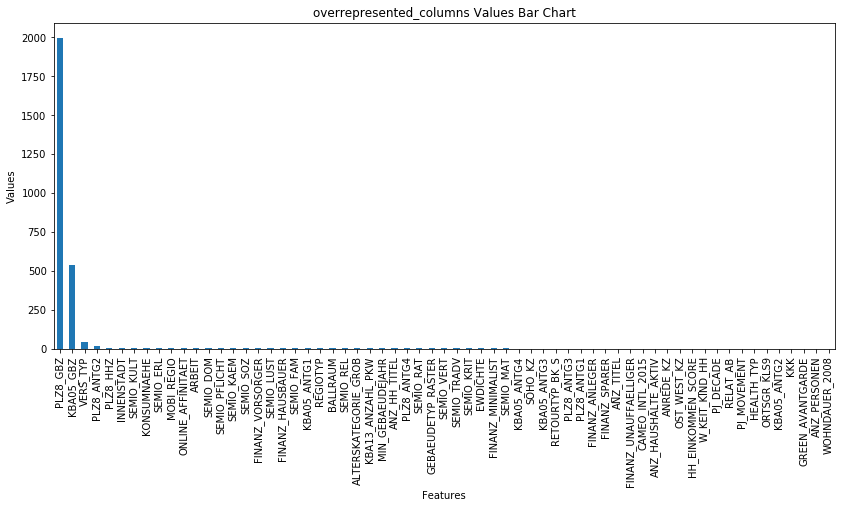

PLZ8_GBZ                 1992.444384
KBA05_GBZ                 539.998782
VERS_TYP                   46.310780
PLZ8_ANTG2                 17.284306
PLZ8_HHZ                    8.231732
INNENSTADT                  6.897543
SEMIO_KULT                  5.569962
KONSUMNAEHE                 5.521198
SEMIO_ERL                   5.256796
MOBI_REGIO                  5.173884
ONLINE_AFFINITAET           5.079208
ARBEIT                      4.979317
SEMIO_DOM                   4.930885
SEMIO_PFLICHT               4.731914
SEMIO_KAEM                  4.692869
SEMIO_SOZ                   4.393111
FINANZ_VORSORGER            4.330951
SEMIO_LUST                  4.139073
FINANZ_HAUSBAUER            4.120964
SEMIO_FAM                   4.002568
KBA05_ANTG1                 3.723551
REGIOTYP                    3.706819
BALLRAUM                    3.689215
SEMIO_REL                   3.521290
ALTERSKATEGORIE_GROB        3.503155
KBA13_ANZAHL_PKW            3.392973
MIN_GEBAEUDEJAHR            3.383669
A

In [194]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# we will investigate cluster 3 where the customer data is significantly larger than the general population
cluster_3 = scaler_gp.inverse_transform(pca_model_80_20.inverse_transform(kmeans_7.cluster_centers_[3]))
overrepresented_columns = pd.Series(data = cluster_3, index=customers_scaled.columns)
#print(overrepresented_columns)

overrepresented_columns = overrepresented_columns.sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(14, 6))
overrepresented_columns.plot(kind='bar')
plt.title('overrepresented_columns Values Bar Chart')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()
print(overrepresented_columns)


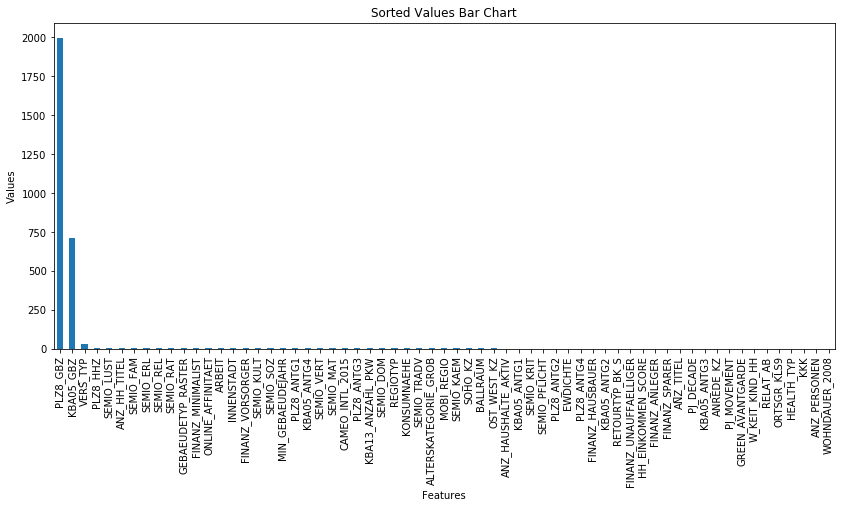

PLZ8_GBZ                 1993.674470
KBA05_GBZ                 714.178795
VERS_TYP                   29.022616
PLZ8_HHZ                    8.309721
SEMIO_LUST                  6.021563
ANZ_HH_TITEL                5.269728
SEMIO_FAM                   5.007564
SEMIO_ERL                   4.936468
SEMIO_REL                   4.854378
SEMIO_RAT                   4.830254
GEBAEUDETYP_RASTER          4.786091
FINANZ_MINIMALIST           4.539776
ONLINE_AFFINITAET           4.443129
ARBEIT                      4.322939
INNENSTADT                  4.286291
FINANZ_VORSORGER            4.275171
SEMIO_KULT                  4.196279
SEMIO_SOZ                   4.008189
MIN_GEBAEUDEJAHR            3.975180
PLZ8_ANTG1                  3.916887
KBA05_ANTG4                 3.798244
SEMIO_VERT                  3.774498
SEMIO_MAT                   3.734590
CAMEO_INTL_2015             3.679986
PLZ8_ANTG3                  3.573131
KBA13_ANZAHL_PKW            3.548406
SEMIO_DOM                   3.498242
R

In [195]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# we will investigate cluster 4 where the customer data is significantly less than the general population
cluster_4 = scaler_gp.inverse_transform(pca_model_80_20.inverse_transform(kmeans_7.cluster_centers_[4]))
underrepresented_columns = pd.Series(data = cluster_4, index=customers_scaled.columns)
# print(underrepresented_columns)

# Sort the Series in descending order
underrepresented_columns = underrepresented_columns.sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(14, 6))
underrepresented_columns.plot(kind='bar')
plt.title('Sorted Values Bar Chart')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()
print(underrepresented_columns)

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)


### Popular segment of the population:

Cluster 3 showed the largest positive difference relative to the general population.
We see (from above) that the top five categories in cluster 1 are:

    >PLZ8_GBZ  It indicates the density of buildings in the area
    >KBA05_GBZ also indicates the density of buildings in the area.
    >VERS_TYP  the type of insurance holder
    >PLZ8_ANTG2 It indicates the density of 6-10 family houses in the area
    >PLZ8_HHZ It indicates the density of households in the area.

    >PLZ8_GBZ                 1992.444384
    >KBA05_GBZ                 539.998782
    >VERS_TYP                   46.310780
    >PLZ8_ANTG2                 17.284306
    >PLZ8_HHZ                    8.231732
    
This suggests a group of people who are highly sensitive to population density


### Un popular segment of the population:

Cluster 3 showed the largest negative difference relative to the general population.
We see (from above) that the top five categories in cluster 3 are:

    >PLZ8_GBZ  It indicates the density of buildings in the area
    >KBA05_GBZ also indicates the density of buildings in the area.
    >VERS_TYP  the type of insurance holder
    >PLZ8_HHZ It indicates the density of households in the area.
    >SEMIO_LUST epresents the affinity for sensual and pleasurable experiences.

    >PLZ8_GBZ                 1993.674470
    >KBA05_GBZ                 714.178795
    >VERS_TYP                   29.022616
    >PLZ8_HHZ                    8.309721
    >SEMIO_LUST                  6.021563
    
This also suggests a group of people who are highly sensitive to population density but in this case
perhaps with more disposable income and inclined to spend on things for pleasure.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [198]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Identify_Customer_Segments.ipynb to html',
 '[NbConvertApp] Writing 1480248 bytes to Identify_Customer_Segments.html']